# Introduction

This notebook simulates the top mass reweighting by using Gaussian with mean and variance of the top mass dataset. It investigates the effect of statistics size to reweighting results. It appears that with large enough data points, the reweighting can work better (around 10^6 in this case)

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="3"

## Imports

In [2]:
# standard library imports
from __future__ import absolute_import, division, print_function

import tensorflow as tf
from tensorflow.keras.layers import Lambda, Dense, Input, Layer, Dropout
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, LambdaCallback
from tensorflow.keras.initializers import Constant
from tensorflow.keras.backend import concatenate

# standard numerical library imports
import numpy as np
import scipy as sp

import matplotlib.pyplot as plt

/home/csuaysom/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/csuaysom/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/csuaysom/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/csuaysom/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.

In [3]:
# Global plot settings
from matplotlib import rc
import matplotlib.font_manager
rc('font', family='serif')
rc('text', usetex=True)
rc('font', size=22) 
rc('xtick', labelsize=15) 
rc('ytick', labelsize=15) 
rc('legend', fontsize=15)

# Using mean and standard deviation value from real top mass dataset to reweight from $\mathcal{N}(\mu_0, \sigma_0)$ to $\mathcal{N}(\mu_1, \sigma_1)$

In [4]:
data_dir = 'DCTRFitting/'
default_had_mass = np.load(data_dir + 'part_172_5_6j_obs_x4.npy')[:,1]
truth_had_mass = np.load(data_dir+ 'part_175_0_6j_obs_x4.npy')[:,1]

In [5]:
(mu_0,sigma_0) = np.average(default_had_mass),np.std(default_had_mass)
(mu_1,sigma_1) = np.average(truth_had_mass),np.std(truth_had_mass)

In [6]:
print(mu_0,sigma_0,mu_1,sigma_1)

200.36699082389325 101.76187520314188 202.56594507000284 102.98617012761439


## Build datasets

In [7]:
def reweight(n_data_points):
    X0 = np.random.normal(mu_0, sigma_0, n_data_points)
    X1 = np.random.normal(mu_1, sigma_1, n_data_points)
    
    bins = np.linspace(-100,500,50)
    plt.hist(X0, bins = bins, alpha = 0.5, label = r'$\mu=172.5$')
    plt.hist(X1, bins = bins, alpha = 0.5, label = r'$\mu=175$')
    plt.legend()
    plt.title("Data for reweighting")
    plt.show()

    Y0 = to_categorical(np.zeros(n_data_points), num_classes=2)
    Y1 = to_categorical(np.ones(n_data_points), num_classes=2)

    X = np.concatenate((X0, X1))
    Y = np.concatenate((Y0, Y1))

    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
    
    inputs = Input((1,))
    hidden_layer_1 = Dense(20, activation='relu')(inputs)
    hidden_layer_2 = Dense(20, activation='relu')(hidden_layer_1)
    hidden_layer_3 = Dense(20, activation='relu')(hidden_layer_2)

    outputs = Dense(2, activation='softmax')(hidden_layer_3)

    model = Model(inputs = inputs, outputs = outputs)
    model.compile(loss='categorical_crossentropy', optimizer='Adam', )
    
    epochs_num = 10
    earlystopping = EarlyStopping(patience = epochs_num,)

    history = model.fit(X_train, Y_train, 
              epochs=epochs_num, 
              batch_size = 100,
              validation_data = (X_test, Y_test),
              callbacks = [earlystopping])
    plt.plot(history.history['loss'],     label = 'loss')
    plt.plot(history.history['val_loss'], label = 'val loss')
    plt.legend(loc=0)
    plt.ylabel('loss')
    plt.xlabel('Epochs')
    plt.show()
    
    X0_val = np.random.normal(mu_0, sigma_0, n_data_points)
    X1_val = np.random.normal(mu_1, sigma_1, n_data_points)
    
    preds = model.predict(X0_val)
    weights = preds[:,1]/preds[:,0]
    
    bins = np.linspace(0.5,1.5,50)
    plt.hist(weights, bins = bins, alpha = 0.5)[0]
    plt.title("Distribution of weight")
    plt.show()
    
    bins = np.linspace(-100,500,50)
    plt.hist(X0_val, bins = bins, alpha = 0.5, label = r'$\mu=172.5$')
    plt.hist(X0_val, bins = bins, label = r'$172.5$ weighted', weights=weights, histtype='step', color='k')
    plt.hist(X1_val, bins = bins, alpha = 0.5, label = r'$\mu=175$')
    plt.legend()
    plt.show()

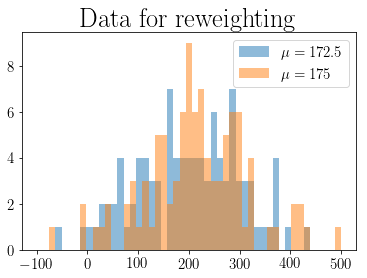

Train on 160 samples, validate on 40 samples
Epoch 1/10
160/160 [==============================] - 2s 15ms/step - loss: 6.7675 - val_loss: 4.7333
Epoch 2/10
160/160 [==============================] - 0s 82us/step - loss: 5.7357 - val_loss: 3.5846
Epoch 3/10
160/160 [==============================] - 0s 78us/step - loss: 4.2325 - val_loss: 2.2397
Epoch 4/10
160/160 [==============================] - 0s 92us/step - loss: 2.6114 - val_loss: 1.0155
Epoch 5/10
160/160 [==============================] - 0s 77us/step - loss: 1.0749 - val_loss: 0.9085
Epoch 6/10
160/160 [==============================] - 0s 89us/step - loss: 1.0211 - val_loss: 1.8043
Epoch 7/10
160/160 [==============================] - 0s 105us/step - loss: 1.5977 - val_loss: 2.1199
Epoch 8/10
160/160 [==============================] - 0s 94us/step - loss: 1.7486 - val_loss: 1.9391
Epoch 9/10
160/160 [==============================] - 0s 116us/step - loss: 1.5378 - val_loss: 1.4398
Epoch 10/10
160/160 [=======================

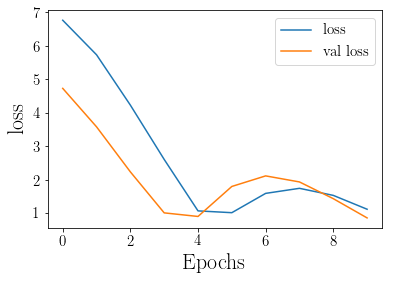

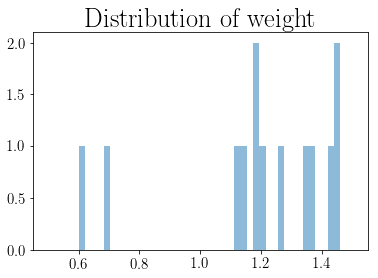

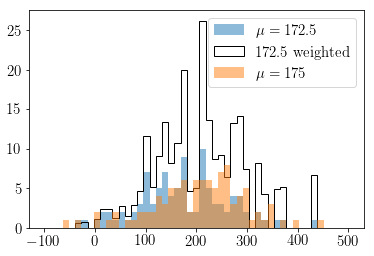

In [8]:
reweight(10**2)

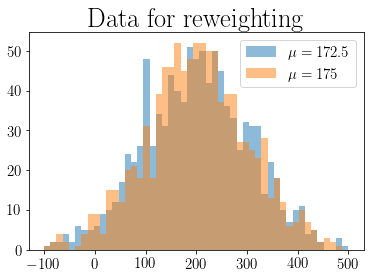

Train on 1600 samples, validate on 400 samples
Epoch 1/10
1600/1600 [==============================] - 1s 472us/step - loss: 4.7855 - val_loss: 0.8332
Epoch 2/10
1600/1600 [==============================] - 0s 70us/step - loss: 1.1109 - val_loss: 0.9784
Epoch 3/10
1600/1600 [==============================] - 0s 68us/step - loss: 0.8148 - val_loss: 0.7044
Epoch 4/10
1600/1600 [==============================] - 0s 69us/step - loss: 0.7291 - val_loss: 0.7078
Epoch 5/10
1600/1600 [==============================] - 0s 76us/step - loss: 0.6975 - val_loss: 0.7076
Epoch 6/10
1600/1600 [==============================] - 0s 64us/step - loss: 0.7009 - val_loss: 0.7052
Epoch 7/10
1600/1600 [==============================] - 0s 74us/step - loss: 0.6984 - val_loss: 0.6932
Epoch 8/10
1600/1600 [==============================] - 0s 76us/step - loss: 0.6963 - val_loss: 0.6927
Epoch 9/10
1600/1600 [==============================] - 0s 64us/step - loss: 0.6968 - val_loss: 0.6931
Epoch 10/10
1600/1600 [==

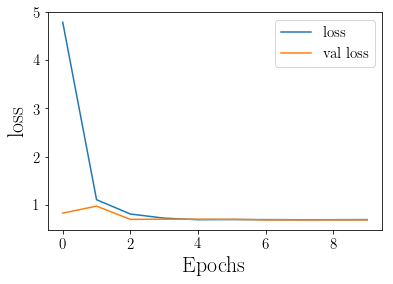

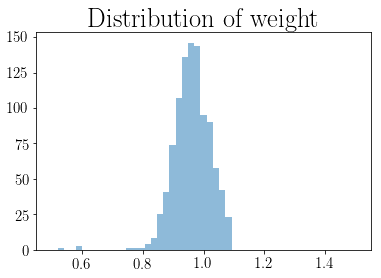

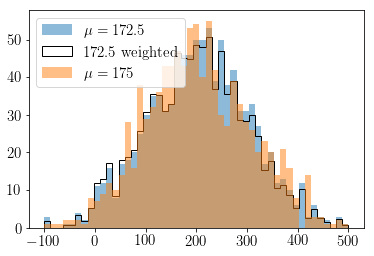

In [9]:
reweight(10**3)

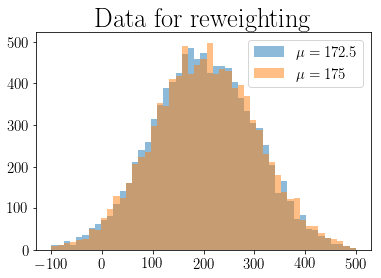

Train on 16000 samples, validate on 4000 samples
Epoch 1/10
16000/16000 [==============================] - 2s 114us/step - loss: 1.5072 - val_loss: 0.6987
Epoch 2/10
16000/16000 [==============================] - 1s 69us/step - loss: 0.7106 - val_loss: 0.6961
Epoch 3/10
16000/16000 [==============================] - 1s 71us/step - loss: 0.7111 - val_loss: 0.6928
Epoch 4/10
16000/16000 [==============================] - 1s 68us/step - loss: 0.7086 - val_loss: 0.6977
Epoch 5/10
16000/16000 [==============================] - 1s 71us/step - loss: 0.7072 - val_loss: 0.7282
Epoch 6/10
16000/16000 [==============================] - 1s 68us/step - loss: 0.7249 - val_loss: 0.6953
Epoch 7/10
16000/16000 [==============================] - 1s 69us/step - loss: 0.7130 - val_loss: 0.8290
Epoch 8/10
16000/16000 [==============================] - 1s 71us/step - loss: 0.7213 - val_loss: 0.6999
Epoch 9/10
16000/16000 [==============================] - 1s 70us/step - loss: 0.7143 - val_loss: 0.6993
Epoch

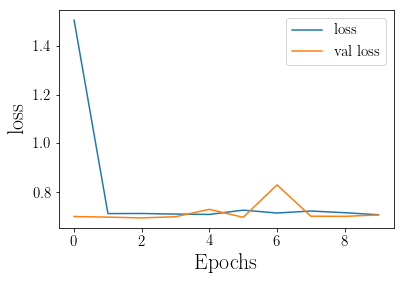

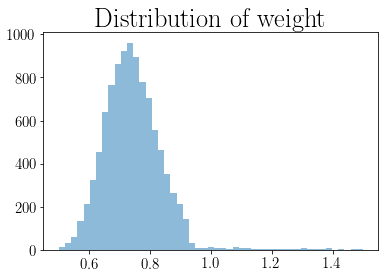

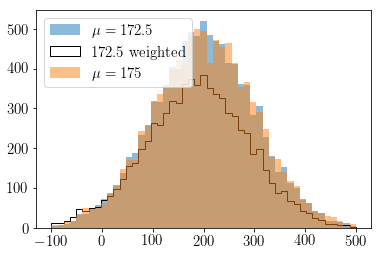

In [10]:
reweight(10**4)

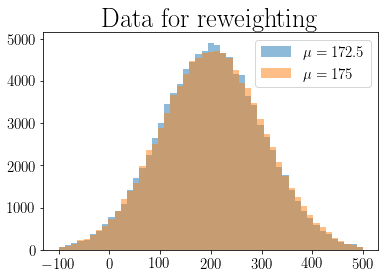

Train on 160000 samples, validate on 40000 samples
Epoch 1/10
160000/160000 [==============================] - 12s 73us/step - loss: 0.7971 - val_loss: 0.7700
Epoch 2/10
160000/160000 [==============================] - 11s 68us/step - loss: 0.7248 - val_loss: 0.7191
Epoch 3/10
160000/160000 [==============================] - 10s 63us/step - loss: 0.7175 - val_loss: 0.6963
Epoch 4/10
160000/160000 [==============================] - 11s 69us/step - loss: 0.7157 - val_loss: 0.7314
Epoch 5/10
160000/160000 [==============================] - 11s 70us/step - loss: 0.7121 - val_loss: 0.6935
Epoch 6/10
160000/160000 [==============================] - 11s 66us/step - loss: 0.7086 - val_loss: 0.6987
Epoch 7/10
160000/160000 [==============================] - 10s 65us/step - loss: 0.7062 - val_loss: 0.7061
Epoch 8/10
160000/160000 [==============================] - 11s 70us/step - loss: 0.7008 - val_loss: 0.6962
Epoch 9/10
160000/160000 [==============================] - 11s 69us/step - loss: 0.6

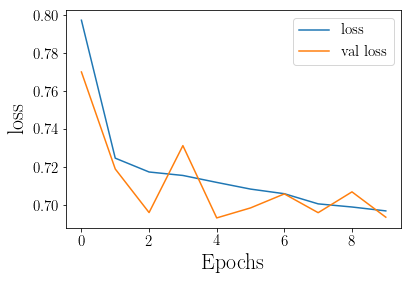

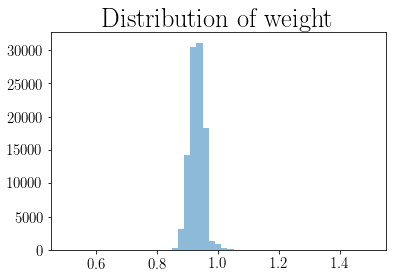

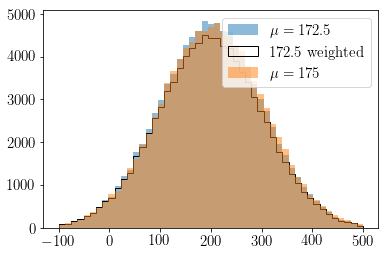

In [11]:
reweight(10**5)

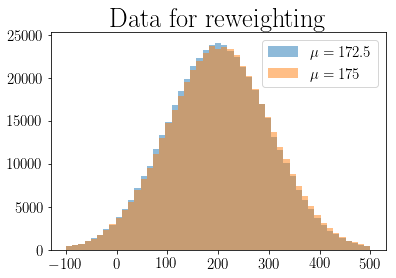

Train on 800000 samples, validate on 200000 samples
Epoch 1/10
800000/800000 [==============================] - 54s 68us/step - loss: 0.7289 - val_loss: 0.6939
Epoch 2/10
800000/800000 [==============================] - 55s 69us/step - loss: 0.6975 - val_loss: 0.6931
Epoch 3/10
800000/800000 [==============================] - 54s 68us/step - loss: 0.6932 - val_loss: 0.6932
Epoch 4/10
800000/800000 [==============================] - 55s 69us/step - loss: 0.6932 - val_loss: 0.6932
Epoch 5/10
800000/800000 [==============================] - 50s 62us/step - loss: 0.6932 - val_loss: 0.6931
Epoch 6/10
800000/800000 [==============================] - 36s 45us/step - loss: 0.6932 - val_loss: 0.6931
Epoch 7/10
800000/800000 [==============================] - 35s 44us/step - loss: 0.6932 - val_loss: 0.6932
Epoch 8/10
800000/800000 [==============================] - 36s 44us/step - loss: 0.6932 - val_loss: 0.6932
Epoch 9/10
800000/800000 [==============================] - 36s 45us/step - loss: 0.

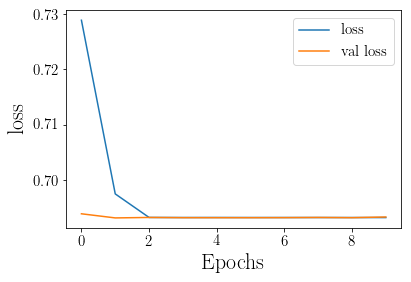

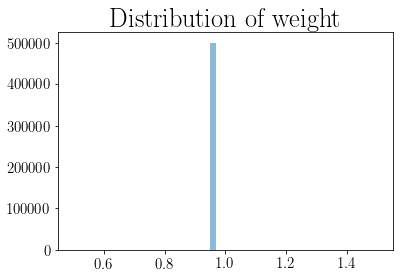

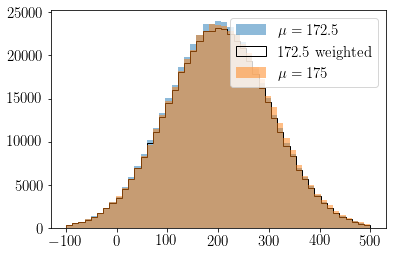

In [12]:
reweight(5*10**5)

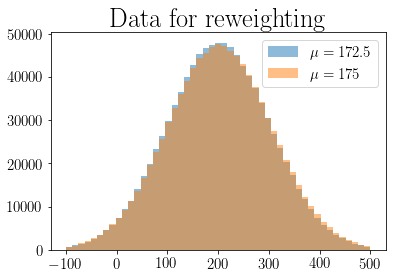

Train on 1600000 samples, validate on 400000 samples
Epoch 1/10
1600000/1600000 [==============================] - 72s 45us/step - loss: 0.6965 - val_loss: 0.6932
Epoch 2/10
1600000/1600000 [==============================] - 71s 45us/step - loss: 0.6932 - val_loss: 0.6932
Epoch 3/10
1600000/1600000 [==============================] - 72s 45us/step - loss: 0.6932 - val_loss: 0.6931
Epoch 4/10
1600000/1600000 [==============================] - 73s 45us/step - loss: 0.6932 - val_loss: 0.6931
Epoch 5/10
1600000/1600000 [==============================] - 73s 45us/step - loss: 0.6932 - val_loss: 0.6931
Epoch 6/10
1600000/1600000 [==============================] - 73s 45us/step - loss: 0.6932 - val_loss: 0.6932
Epoch 7/10
1600000/1600000 [==============================] - 73s 45us/step - loss: 0.6932 - val_loss: 0.6932
Epoch 8/10
1600000/1600000 [==============================] - 73s 45us/step - loss: 0.6932 - val_loss: 0.6931
Epoch 9/10
1600000/1600000 [==============================] - 73s 4

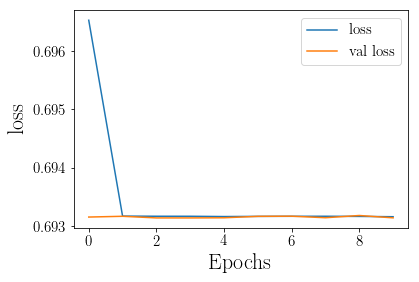

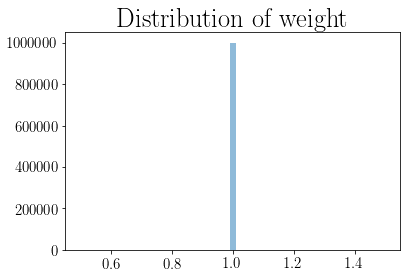

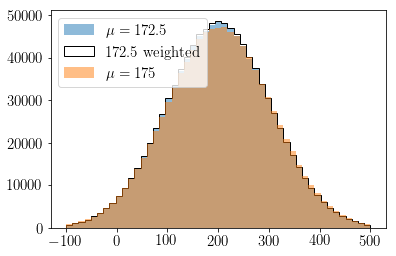

In [13]:
reweight(10**6)

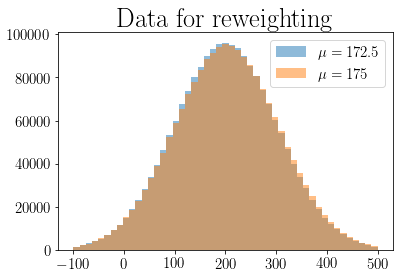

Train on 3200000 samples, validate on 800000 samples
Epoch 1/10
3200000/3200000 [==============================] - 161s 50us/step - loss: 0.6996 - val_loss: 0.6932
Epoch 2/10
3200000/3200000 [==============================] - 158s 49us/step - loss: 0.6932 - val_loss: 0.6933
Epoch 3/10
3200000/3200000 [==============================] - 158s 49us/step - loss: 0.6932 - val_loss: 0.6932
Epoch 4/10
3200000/3200000 [==============================] - 159s 50us/step - loss: 0.6932 - val_loss: 0.6932
Epoch 5/10
3200000/3200000 [==============================] - 159s 50us/step - loss: 0.6932 - val_loss: 0.6931
Epoch 6/10
3200000/3200000 [==============================] - 159s 50us/step - loss: 0.6932 - val_loss: 0.6932
Epoch 7/10
3200000/3200000 [==============================] - 158s 49us/step - loss: 0.6932 - val_loss: 0.6932
Epoch 8/10
3200000/3200000 [==============================] - 158s 50us/step - loss: 0.6932 - val_loss: 0.6931
Epoch 9/10
3200000/3200000 [==============================]

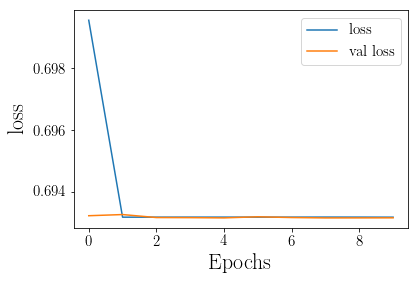

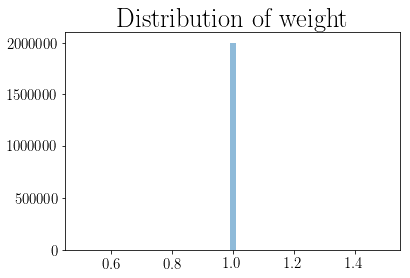

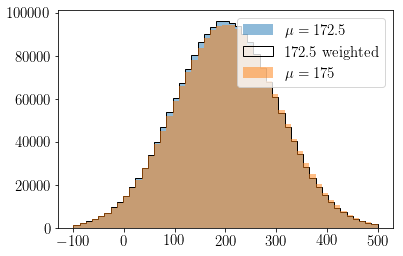

In [14]:
reweight(2*10**6)